This notebook contains the code for our best model, e.g. the model with the best performance. Some outputs are left in place (specifically the training process of the model). The best model is *model_8.pth*, we attach it with the notebook to the submission.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from PIL import Image
import torchvision.models as models

import os

In [ ]:
!pip install torchmetrics

In [ ]:
import torchmetrics

DATA LOADING

We used the Cityscapes dataset from: https://www.cityscapes-dataset.com/downloads/
We require archives gtFine_trainvaltest.zip and leftImg8bit_trainvaltest.zip
We uploaded them on Google Drive and as a dataset on Kaggle, so the following cells perform downloading/preparing the dataset.

### for Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Cityscapes/leftImg8bit_trainvaltest.zip -d /content/cityscapes
!unzip /content/drive/MyDrive/Cityscapes/gtFine_trainvaltest.zip -d /content/cityscapes

### for Kaggle

This is just an auxilliary code to move everything from a Kaggle dataset to /kaggle/working directory. A dataset stores the data in a way, which does not allow us to simply use *Cityscapes* function from *torchvision* to download it. So, we had to move it manually to /kaggle/working to ensure that everything is in a proper format.

In [ ]:
import os
import shutil

base_dir = '/kaggle/input/cityscapes'
gtfine_trainvaltest_dir = os.path.join(base_dir, 'gtFine_trainvaltest', 'gtFine')
leftimg8bit_trainvaltest_dir = os.path.join(base_dir, 'leftImg8bit_trainvaltest', 'leftImg8bit')

working_dir = '/kaggle/working'
gtfine_dir = os.path.join(working_dir, 'gtFine')
leftimg8bit_dir = os.path.join(working_dir, 'leftImg8bit')

exclude_files = ['README', 'license.txt']

os.makedirs(gtfine_dir, exist_ok=True)
os.makedirs(leftimg8bit_dir, exist_ok=True)

def copy_files_and_directories(source_dir, target_dir):
    """
    Copies files and subdirectories from the source directory to the target directory,
    excluding certain files, and keeping the directory structure.
    """
    for root, dirs, files in os.walk(source_dir, topdown=True):
        dirs[:] = [d for d in dirs if d not in exclude_files]
        relative_path = os.path.relpath(root, source_dir)

        for file in files:
            if file not in exclude_files:
                source_path = os.path.join(root, file)
                target_path = os.path.join(target_dir, relative_path, file)
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                shutil.copy(source_path, target_path)

copy_files_and_directories(gtfine_trainvaltest_dir, gtfine_dir)
copy_files_and_directories(leftimg8bit_trainvaltest_dir, leftimg8bit_dir)

Next cell perform removing the Kaggle dataset from /kaggle/working if necessary

In [ ]:
# import shutil

# working_dir = '/kaggle/working'

# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     if os.path.isdir(item_path):
#         shutil.rmtree(item_path)
#     else:
#         os.remove(item_path)

### Data preprocessing

Here we map 35 classes from Cityscapes to 20, transform and download data into *Dataloader* objects.

In [2]:
mapping_20 = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 2,
    9: 0,
    10: 0,
    11: 3,
    12: 4,
    13: 5,
    14: 0,
    15: 0,
    16: 0,
    17: 6,
    18: 0,
    19: 7,
    20: 8,
    21: 9,
    22: 10,
    23: 11,
    24: 12,
    25: 13,
    26: 14,
    27: 15,
    28: 16,
    29: 0,
    30: 0,
    31: 17,
    32: 18,
    33: 19,
    -1: 0
}

def encode_labels(mask):
    label_mask = torch.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

transform_target = transforms.Compose([
    transforms.Resize((512, 1024)),
    #transforms.ToTensor(),
    transforms.Lambda(transforms.functional.pil_to_tensor),
    transforms.Lambda(torch.squeeze),
    transforms.Lambda(lambda x: x.long()),
    #transforms.Lambda(lambda x: x - torch.ones_like(x))
    transforms.Lambda(encode_labels)
])

train_dataset = torchvision.datasets.Cityscapes(root='/kaggle/working', split='train', mode='fine', target_type='semantic', transform=transform, target_transform=transform_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = torchvision.datasets.Cityscapes(root='/kaggle/working', split='val', mode='fine', target_type='semantic', transform=transform, target_transform=transform_target)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

len(train_dataset)

2975

### Feature Extractor loading and editing

In [ ]:
densenet_model = models.densenet121(pretrained=True)
for param in densenet_model.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
x = torch.randn(1, 3, 512, 512)
output = densenet_model.features(x)
print(output.shape)

torch.Size([1, 1024, 16, 16])


Next cell removes two last pooling layers and sets *dilation* and *padding* parameters of denseblocks following removed layers to ensure that all weights are reused properly.

In [ ]:
densenet_model.features.transition2.pool = nn.Identity()
densenet_model.features.transition3.pool = nn.Identity()
for dlayer_name, dlayer in densenet_model.features.denseblock3.named_children():
  dlayer.conv2.dilation = (2, 2)
  dlayer.conv2.padding = (2, 2)
for dlayer_name, dlayer in densenet_model.features.denseblock4.named_children():
  dlayer.conv2.dilation = (4, 4)
  dlayer.conv2.padding = (4, 4)

In [ ]:
for param in densenet_model.features.parameters():
    param.requires_grad = False

In [ ]:
#densenet_model.features

In [ ]:
x = torch.randn(1, 3, 512, 512)
output = densenet_model.features(x)
print(output.shape)

torch.Size([1, 1024, 64, 64])


### Defining the model

In [3]:
class DenseASPPModule(nn.Module):
    def __init__(self, in_channels, growth_rate, dilation_rates, reduced_channels=256):
        super(DenseASPPModule, self).__init__()
        self.layers = nn.ModuleList()
        self.growth_rate = growth_rate

        current_channels = in_channels
        for dilation in dilation_rates:
            self.layers.append(
                nn.Sequential(
                    nn.BatchNorm2d(current_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(current_channels, reduced_channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(reduced_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(reduced_channels, growth_rate, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                )
            )
            current_channels += growth_rate

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, dim=1))
            features.append(new_feature)
        return torch.cat(features, dim=1)

class DenseASPP(nn.Module):
    def __init__(self, base_model, in_channels, num_classes=19, growth_rate=32, dilation_rates=[6, 12, 18, 24]):
        super(DenseASPP, self).__init__()

        self.feature_extractor = base_model.features

        #self.addConv = nn.Conv2d(1024, 512, kernel_size=1)
        #self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True) # scale_factor=32 to get the initial size

        self.dense_aspp = DenseASPPModule(in_channels=1024, growth_rate=growth_rate, dilation_rates=dilation_rates)

        self.classifier = nn.Sequential(
            nn.Conv2d(1024 + len(dilation_rates) * growth_rate, num_classes, kernel_size=1),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        #x = self.addConv(x)
        #x = self.upsample(x)
        x = self.dense_aspp(x)
        x = self.classifier(x)
        return x

In [ ]:
model = DenseASPP(base_model=densenet_model, in_channels=3, num_classes=20, growth_rate=64, dilation_rates=[3, 6, 12, 18, 24])
#print(model)

#Example input
input_tensor = torch.randn(1, 3, 512, 1024)

to_pil = torchvision.transforms.ToPILImage()
image = to_pil(torch.squeeze(input_tensor))
image.show()

output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 20, 512, 1024])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 2252820


### Train

In [ ]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(trainable_params, lr=0.0003, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

In [4]:
from tqdm import tqdm

In [ ]:
loss_history = []

def train_model(model, dataloader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader):
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_history.append(running_loss / len(dataloader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
train_model(model, train_loader, optimizer, criterion, 60)

100%|██████████| 372/372 [11:05<00:00,  1.79s/it]


Epoch 1/60, Loss: 0.6408689039689238


100%|██████████| 372/372 [11:02<00:00,  1.78s/it]


Epoch 2/60, Loss: 0.4510653690304807


100%|██████████| 372/372 [11:08<00:00,  1.80s/it]


Epoch 3/60, Loss: 0.41167153642382676


100%|██████████| 372/372 [11:10<00:00,  1.80s/it]


Epoch 4/60, Loss: 0.3862837210137357


100%|██████████| 372/372 [11:11<00:00,  1.81s/it]


Epoch 5/60, Loss: 0.36935625569794767


100%|██████████| 372/372 [11:11<00:00,  1.81s/it]


Epoch 6/60, Loss: 0.3548079504761645


100%|██████████| 372/372 [11:09<00:00,  1.80s/it]


Epoch 7/60, Loss: 0.3406346434306714


100%|██████████| 372/372 [11:13<00:00,  1.81s/it]


Epoch 8/60, Loss: 0.3298328749194581


100%|██████████| 372/372 [11:13<00:00,  1.81s/it]


Epoch 9/60, Loss: 0.3169153558631097


100%|██████████| 372/372 [11:15<00:00,  1.82s/it]


Epoch 10/60, Loss: 0.3074120541894308


100%|██████████| 372/372 [11:07<00:00,  1.79s/it]


Epoch 11/60, Loss: 0.2975121879930137


100%|██████████| 372/372 [10:56<00:00,  1.77s/it]


Epoch 12/60, Loss: 0.29068832123471844


100%|██████████| 372/372 [11:03<00:00,  1.78s/it]


Epoch 13/60, Loss: 0.28211857598795687


100%|██████████| 372/372 [11:04<00:00,  1.79s/it]


Epoch 14/60, Loss: 0.28035945341151247


100%|██████████| 372/372 [11:00<00:00,  1.78s/it]


Epoch 15/60, Loss: 0.2739909042113571


100%|██████████| 372/372 [10:47<00:00,  1.74s/it]


Epoch 16/60, Loss: 0.2660780584700005


100%|██████████| 372/372 [10:41<00:00,  1.72s/it]


Epoch 17/60, Loss: 0.25950757121687296


100%|██████████| 372/372 [10:50<00:00,  1.75s/it]


Epoch 18/60, Loss: 0.25601883677224957


100%|██████████| 372/372 [11:02<00:00,  1.78s/it]


Epoch 19/60, Loss: 0.2516720687109296


100%|██████████| 372/372 [11:04<00:00,  1.79s/it]


Epoch 20/60, Loss: 0.24806609028770077


100%|██████████| 372/372 [11:02<00:00,  1.78s/it]


Epoch 21/60, Loss: 0.25306043737838346


100%|██████████| 372/372 [10:58<00:00,  1.77s/it]


Epoch 22/60, Loss: 0.24121769141125424


100%|██████████| 372/372 [10:47<00:00,  1.74s/it]


Epoch 23/60, Loss: 0.2397674250426472


100%|██████████| 372/372 [10:24<00:00,  1.68s/it]


Epoch 24/60, Loss: 0.24599054892377187


100%|██████████| 372/372 [10:19<00:00,  1.67s/it]


Epoch 25/60, Loss: 0.24278756883996788


100%|██████████| 372/372 [10:17<00:00,  1.66s/it]


Epoch 26/60, Loss: 0.22628376777133635


100%|██████████| 372/372 [10:22<00:00,  1.67s/it]


Epoch 27/60, Loss: 0.22493431208434925


100%|██████████| 372/372 [10:47<00:00,  1.74s/it]


Epoch 28/60, Loss: 0.2241622100994792


100%|██████████| 372/372 [10:50<00:00,  1.75s/it]


Epoch 29/60, Loss: 0.2357181283014436


100%|██████████| 372/372 [10:51<00:00,  1.75s/it]


Epoch 30/60, Loss: 0.2201114224810754


100%|██████████| 372/372 [10:36<00:00,  1.71s/it]


Epoch 31/60, Loss: 0.21890736916052397


100%|██████████| 372/372 [10:49<00:00,  1.75s/it]


Epoch 32/60, Loss: 0.2187616567137421


100%|██████████| 372/372 [10:49<00:00,  1.74s/it]


Epoch 33/60, Loss: 0.21417688358054365


100%|██████████| 372/372 [10:47<00:00,  1.74s/it]


Epoch 34/60, Loss: 0.21269480439443741


100%|██████████| 372/372 [10:52<00:00,  1.76s/it]


Epoch 35/60, Loss: 0.2100889045464736


100%|██████████| 372/372 [10:48<00:00,  1.74s/it]


Epoch 36/60, Loss: 0.22542295128267298


100%|██████████| 372/372 [10:38<00:00,  1.72s/it]


Epoch 37/60, Loss: 0.21416683511067464


100%|██████████| 372/372 [10:47<00:00,  1.74s/it]


Epoch 38/60, Loss: 0.20551501919505416


100%|██████████| 372/372 [10:40<00:00,  1.72s/it]


Epoch 39/60, Loss: 0.20217162270539552


100%|██████████| 372/372 [10:44<00:00,  1.73s/it]


Epoch 40/60, Loss: 0.20318386126910487


100%|██████████| 372/372 [10:53<00:00,  1.76s/it]


Epoch 41/60, Loss: 0.20843811120877984


100%|██████████| 372/372 [11:03<00:00,  1.78s/it]


Epoch 42/60, Loss: 0.2116755841560261


100%|██████████| 372/372 [10:56<00:00,  1.77s/it]


Epoch 43/60, Loss: 0.21154141638387916


100%|██████████| 372/372 [10:57<00:00,  1.77s/it]


Epoch 44/60, Loss: 0.1981027322991561


100%|██████████| 372/372 [10:58<00:00,  1.77s/it]


Epoch 45/60, Loss: 0.19580678297306903


100%|██████████| 372/372 [10:54<00:00,  1.76s/it]


Epoch 46/60, Loss: 0.19640695624133592


100%|██████████| 372/372 [10:58<00:00,  1.77s/it]


Epoch 47/60, Loss: 0.200155820697546


100%|██████████| 372/372 [10:56<00:00,  1.77s/it]


Epoch 48/60, Loss: 0.19489459745505805


100%|██████████| 372/372 [11:07<00:00,  1.79s/it]


Epoch 49/60, Loss: 0.1933722046594466


100%|██████████| 372/372 [11:08<00:00,  1.80s/it]


Epoch 50/60, Loss: 0.19588763338904228


100%|██████████| 372/372 [11:08<00:00,  1.80s/it]


Epoch 51/60, Loss: 0.21974432476425684


100%|██████████| 372/372 [11:10<00:00,  1.80s/it]


Epoch 52/60, Loss: 0.20203480144502015


100%|██████████| 372/372 [10:58<00:00,  1.77s/it]


Epoch 53/60, Loss: 0.18922652208035992


100%|██████████| 372/372 [11:00<00:00,  1.78s/it]


Epoch 54/60, Loss: 0.18654960770440357


100%|██████████| 372/372 [11:06<00:00,  1.79s/it]


Epoch 55/60, Loss: 0.18692043680016712


100%|██████████| 372/372 [11:03<00:00,  1.78s/it]


Epoch 56/60, Loss: 0.19069579243659973


100%|██████████| 372/372 [10:54<00:00,  1.76s/it]


Epoch 57/60, Loss: 0.1879884091115767


100%|██████████| 372/372 [11:01<00:00,  1.78s/it]


Epoch 58/60, Loss: 0.18732762148463597


100%|██████████| 372/372 [10:53<00:00,  1.76s/it]


Epoch 59/60, Loss: 0.18711680374158327


100%|██████████| 372/372 [11:06<00:00,  1.79s/it]

Epoch 60/60, Loss: 0.18745035209482716


In [ ]:
torch.save(model.state_dict(), 'model_weights_8.pth')
torch.save(model, 'model_8.pth')

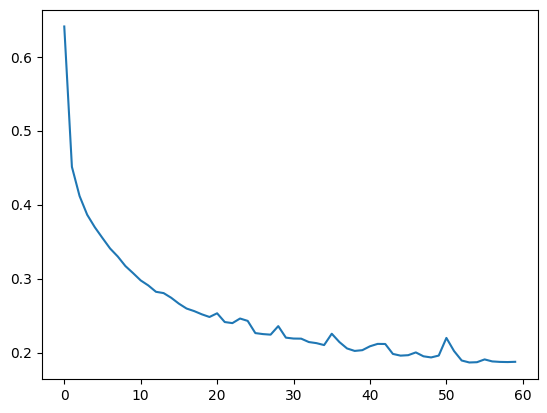

In [ ]:
plt.plot(loss_history)

### Validation

In the next cell and further: if you use GPU, while downloading the model, *map_location* parameter should be set to 'cuda'.

In [12]:
model_test = torch.load('model_8.pth', map_location=torch.device('cpu'))

<ipython-input-12-789c4f2bcfcf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test = torch.load('model_8.pth', map_location=torch.device('cpu'))


torch.Size([1, 3, 512, 1024])


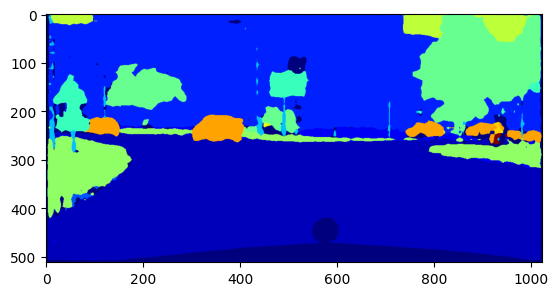

In [13]:
# Manual check of the model results

model_test.eval()

image = Image.open("aachen.png").convert("RGB")
image.show()
preprocess = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)
print(input_tensor.shape)

#input_tensor = input_tensor.to('cuda')
with torch.no_grad():
    output = model_test(input_tensor)

output_predictions = output.cpu().argmax(1).squeeze().numpy()

plt.imshow(output_predictions, cmap='jet')
plt.show()

In [ ]:
def calculate_miou(conf_matrix):
    # calculate miou from confusion matrix
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou = intersection / np.maximum(union, 1)
    return np.nanmean(iou)

def evaluate_model(model, test_loader, num_classes, device='cuda'):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            for pred, label in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                conf_matrix += confusion_matrix(
                    label.flatten(),
                    pred.flatten(),
                    labels=np.arange(num_classes)
                )

    miou = calculate_miou(conf_matrix)
    return miou

In [ ]:
evaluate_model(model, test_loader, num_classes=20, device='cuda')

100%|██████████| 63/63 [02:08<00:00,  2.04s/it]


0.5403833973076138

### Experiments

In [6]:
model_test = torch.load('model_8.pth', map_location=torch.device('cpu'))

<ipython-input-6-789c4f2bcfcf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test = torch.load('model_8.pth', map_location=torch.device('cpu'))


In [5]:
dict_labels = {
    0: 'unlabeled',
    1: 'road',
    2: 'sidewalk',
    3: 'building',
    4: 'wall',
    5: 'fence',
    6: 'pole',
    7: 'traffic light',
    8: 'traffic sign',
    9: 'vegetation',
    10: 'terrain',
    11: 'sky',
    12: 'person',
    13: 'rider',
    14: 'car',
    15: 'truck',
    16: 'bus',
    17: 'train',
    18: 'motorcycle',
    19: 'bicycle'
}

The function in the next cell performs similarity analysis of all the pixels in an image to a fixed class. It outputs a heat map for every class in the ground truth. *city_name* parameter is just for the title of the output.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def feature_similarity_analysis(model, image, ground_truth, city_name="Not provided"):
    model.eval()
    with torch.no_grad():
        features = model(image)
        features = features.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)

    gt = ground_truth.squeeze().cpu().numpy()

    unique_labels = torch.unique(ground_truth)
    heatmaps = []
    for label in unique_labels:
        label_mask = (gt == label.item())
        if label_mask.sum() == 0:
            continue

        feature_subset = features[label_mask]
        mean_feature = feature_subset.mean(axis=0, keepdims=True)
        similarity = cosine_similarity(features.reshape(-1, features.shape[-1]), mean_feature)
        heatmaps.append(similarity.reshape(features.shape[0], features.shape[1]))

    for i, heatmap in enumerate(heatmaps):
        plt.figure()
        plt.title(f"{city_name}: Feature Similarity for Label {dict_labels[unique_labels[i].item()]}")
        plt.imshow(heatmap, cmap="jet")
        plt.colorbar()
        plt.show()

An example of its work:

torch.Size([1, 3, 512, 1024])
torch.Size([1, 512, 1024])


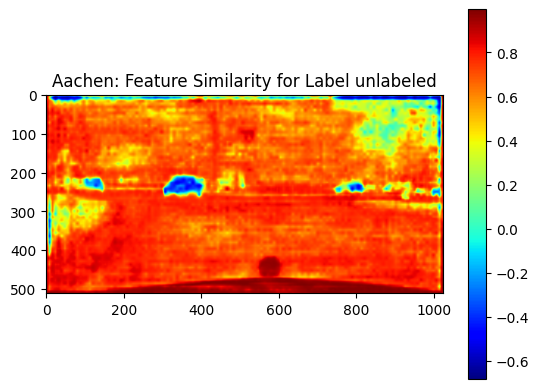

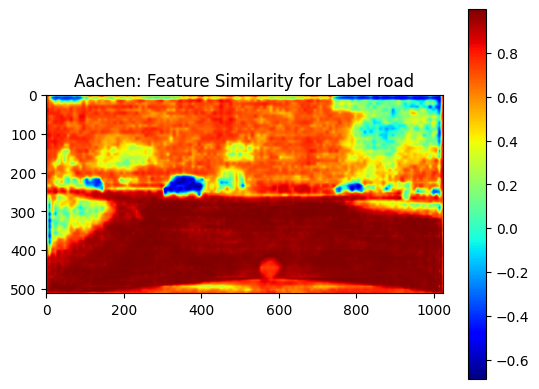

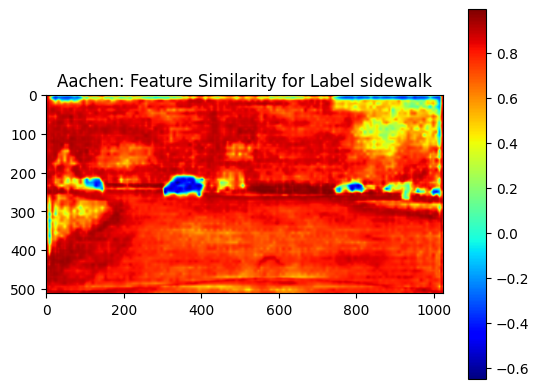

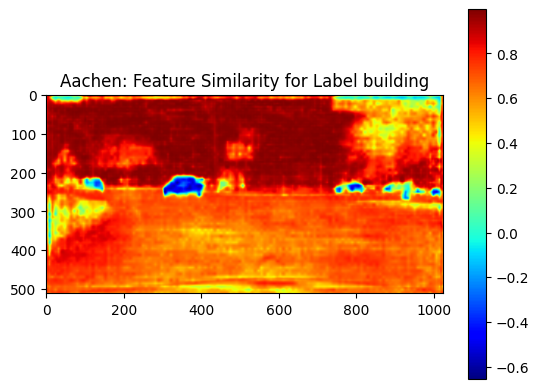

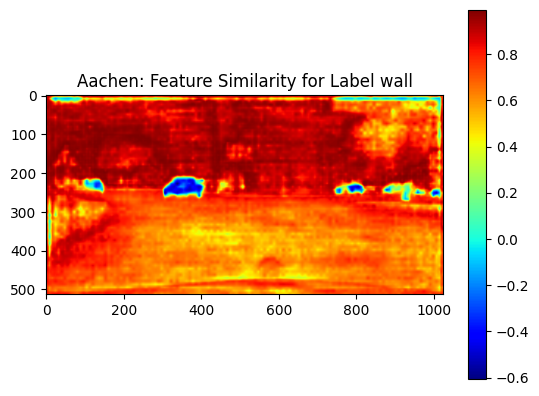

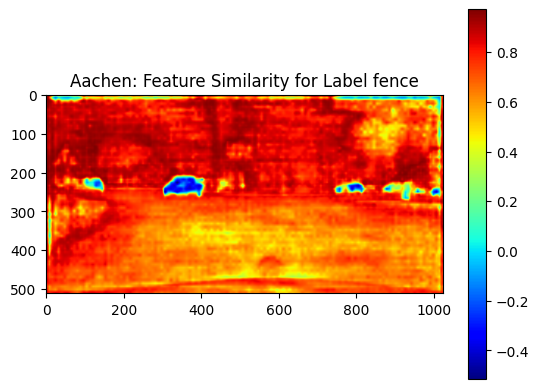

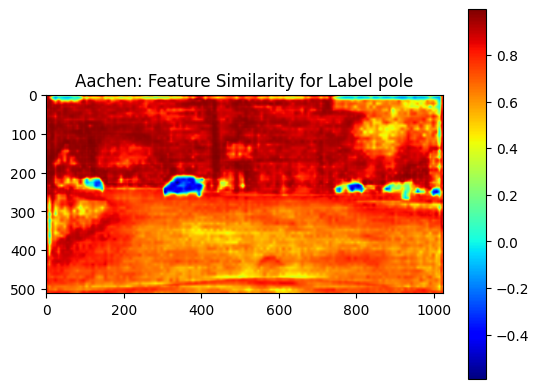

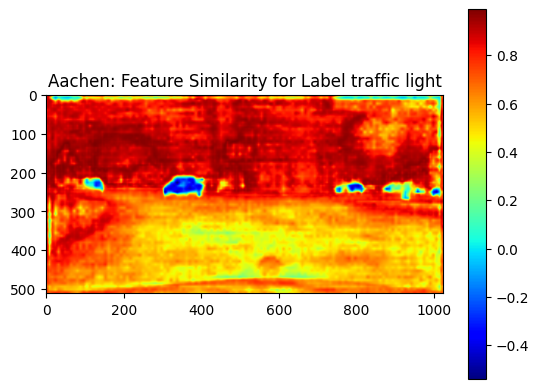

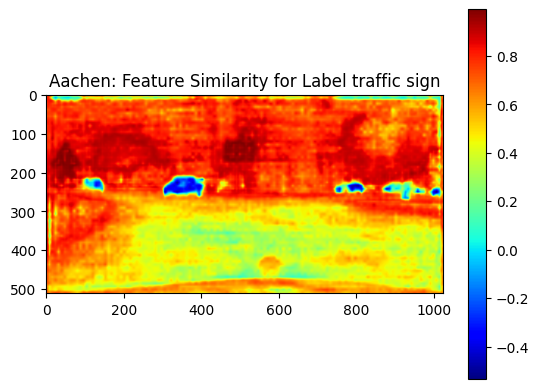

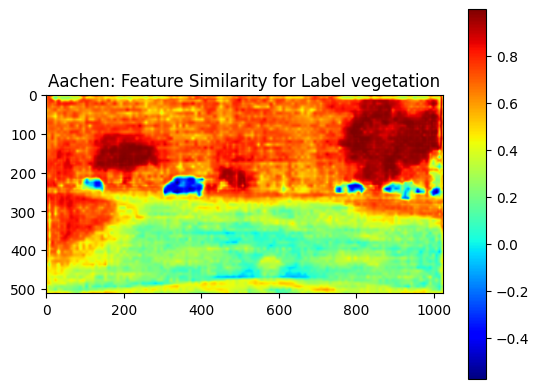

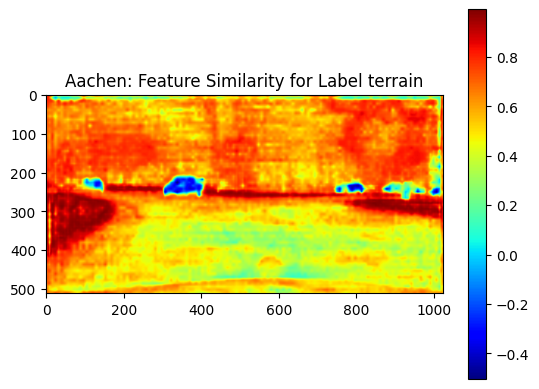

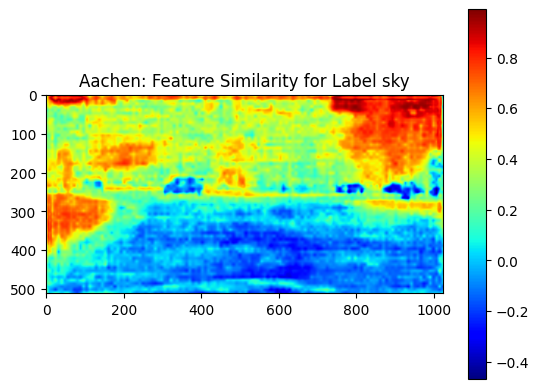

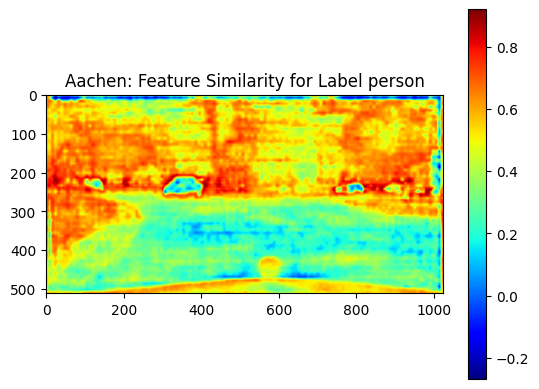

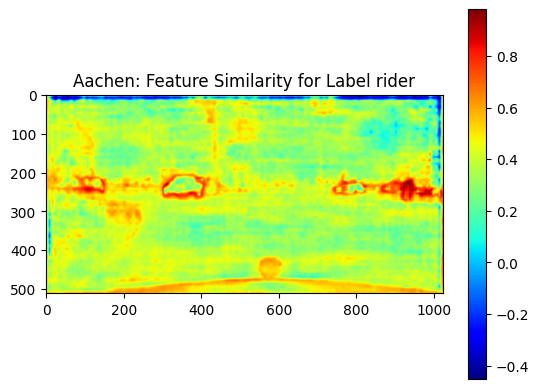

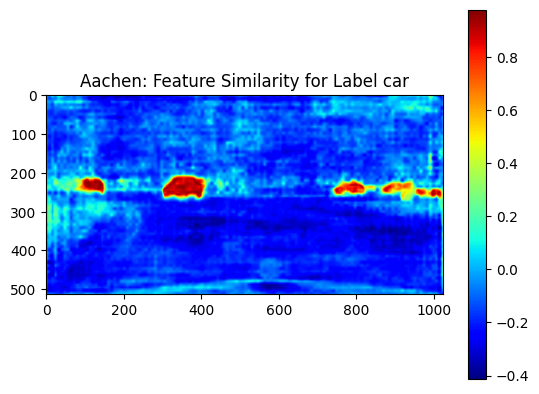

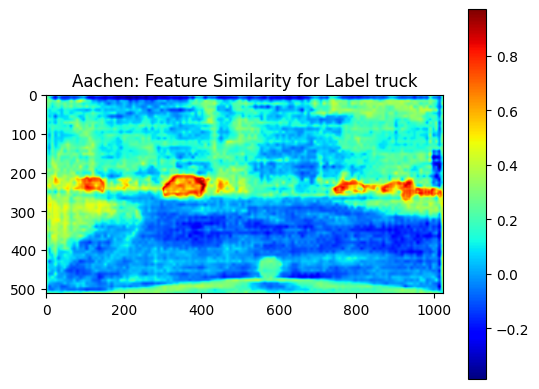

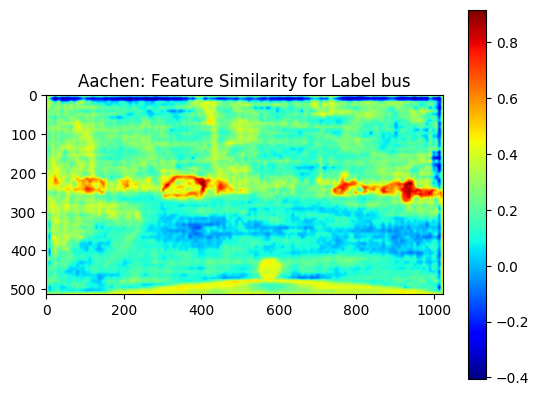

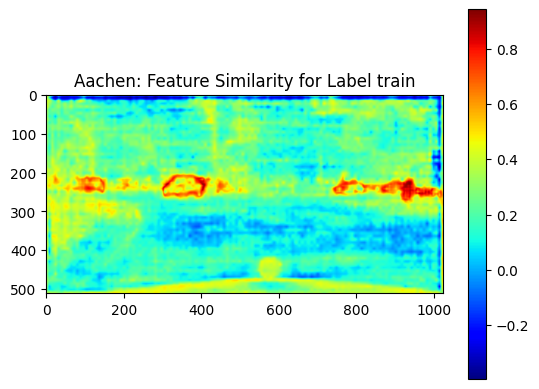

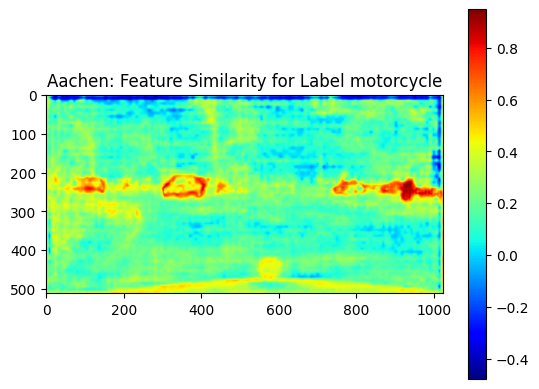

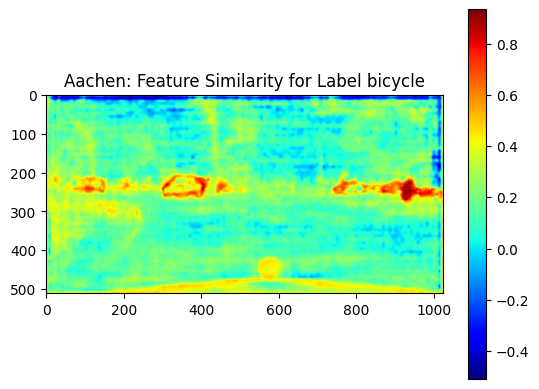

In [11]:
image = Image.open("aachen.png").convert("RGB")
target = Image.open("aachen_labelIds.png")
preprocess = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)
print(input_tensor.shape)

transform_target = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.Lambda(transforms.functional.pil_to_tensor),
    transforms.Lambda(lambda x: x.long()),
    transforms.Lambda(encode_labels)
])
target_tensor = transform_target(target)
print(target_tensor.shape)

feature_similarity_analysis(model_test, input_tensor, target_tensor, city_name='Aachen')

### Similarity Analysis

During the experiments, we stored images from Cityscapes in folders *train* and *val* (with images from train part and val part of the dataset correspondently). The images had names according to the name of the city depicted (e.g. *aachen.png*), the corresponding ground truth files were named as *aachen_labelIds.png*, replacing *aachen* with a required city name.

In [ ]:
val_names = ['frankfurt', 'lindau', 'munster']
train_names = ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover',
               'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']

The following cells outputs a heat map for each class in the ground truth file of each image in the *val* folder (not the dataset, but uploaded manually). The output is removed, because it is too long and can display improperly depending on how you open the notebook.

In [ ]:
for name in val_names:
  path_image = 'val/' + name + '.png'
  path_target = 'val/' + name + '_labelIds.png'
  image = Image.open(path_image).convert("RGB")
  target = Image.open(path_target)
  preprocess = transforms.Compose([
      transforms.Resize((512, 1024)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  input_tensor = preprocess(image).unsqueeze(0)

  transform_target = transforms.Compose([
      transforms.Resize((512, 1024)),
      transforms.Lambda(transforms.functional.pil_to_tensor),
      transforms.Lambda(lambda x: x.long()),
      transforms.Lambda(encode_labels)
  ])
  target_tensor = transform_target(target)

  print("=========================================================================================================")

  feature_similarity_analysis(model_test, input_tensor, target_tensor, name)

The following cells outputs a heat map for each class in the ground truth file of each image in the *train* folder (not the dataset, but uploaded manually). The output is removed, because it is too long and can display improperly depending on how you open the notebook.

In [ ]:
for name in train_names:
  path_image = 'train/' + name + '.png'
  path_target = 'train/' + name + '_labelIds.png'
  image = Image.open(path_image).convert("RGB")
  target = Image.open(path_target)
  preprocess = transforms.Compose([
      transforms.Resize((512, 1024)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  input_tensor = preprocess(image).unsqueeze(0)

  transform_target = transforms.Compose([
      transforms.Resize((512, 1024)),
      transforms.Lambda(transforms.functional.pil_to_tensor),
      transforms.Lambda(lambda x: x.long()),
      transforms.Lambda(encode_labels)
  ])
  target_tensor = transform_target(target)

  print("=========================================================================================================")

  feature_similarity_analysis(model_test, input_tensor, target_tensor, name)

### Top atrous layers removal

The following function performs removal of top layers from the DenseASPP module of our model. It outputs 6 plots with results of subsequently 1, 2, ..., 5 layers being removed. It receives a *city_name* as an input and expects an image to be stored as *city_name.png* and a model stored at *model_path*. Model is uploaded every time and the final classifier convolution is edited to preserve pretrained weights while reducing the width of the final feature map due to some layers' removal.

In [7]:
def reducing_num_layers_study(image_path, model_path):
    growth_rate = 64

    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle(f"Layer removal results:", fontsize=16)

    for num_layers in tqdm(range(6)):
        reduced_model = torch.load(model_path, map_location=torch.device('cpu'))
        if num_layers > 0:
            reduced_model.dense_aspp.layers = nn.ModuleList(
                reduced_model.dense_aspp.layers[:-num_layers]
            )
            classifier_conv = reduced_model.classifier[0]
            original_weights = classifier_conv.weight
            original_bias = classifier_conv.bias

            new_weights = original_weights[:, :1344 - growth_rate * num_layers, :, :]
            classifier_conv.weight.data = new_weights
            classifier_conv.bias.data = original_bias
            reduced_model.classifier[0] = nn.Conv2d(1344 - growth_rate * num_layers, 20, kernel_size=(1, 1), stride=(1, 1))
            reduced_model.classifier[0].weight.data = new_weights
            reduced_model.classifier[0].bias.data = original_bias
        reduced_model.eval()

        image = Image.open(image_path).convert("RGB")
        image.show()
        preprocess = transforms.Compose([
            transforms.Resize((512, 1024)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = preprocess(image).unsqueeze(0)

        #input_tensor = input_tensor.to('cuda')
        with torch.no_grad():
            output = reduced_model(input_tensor)  # Output has shape [C, H, W]

        output_predictions = output.cpu().argmax(1).squeeze().numpy()  # Shape [H, W]

        axes[num_layers//2, num_layers%2].imshow(output_predictions, cmap='jet')
        axes[num_layers//2, num_layers%2].set_title(f"Num of excluded layers: {num_layers}")
        axes[num_layers//2, num_layers%2].axis("off")

    plt.show()

An example of its work:

  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-7-5c9fd91d5fd0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reduced_model = torch.load(model_path, map_location=torc

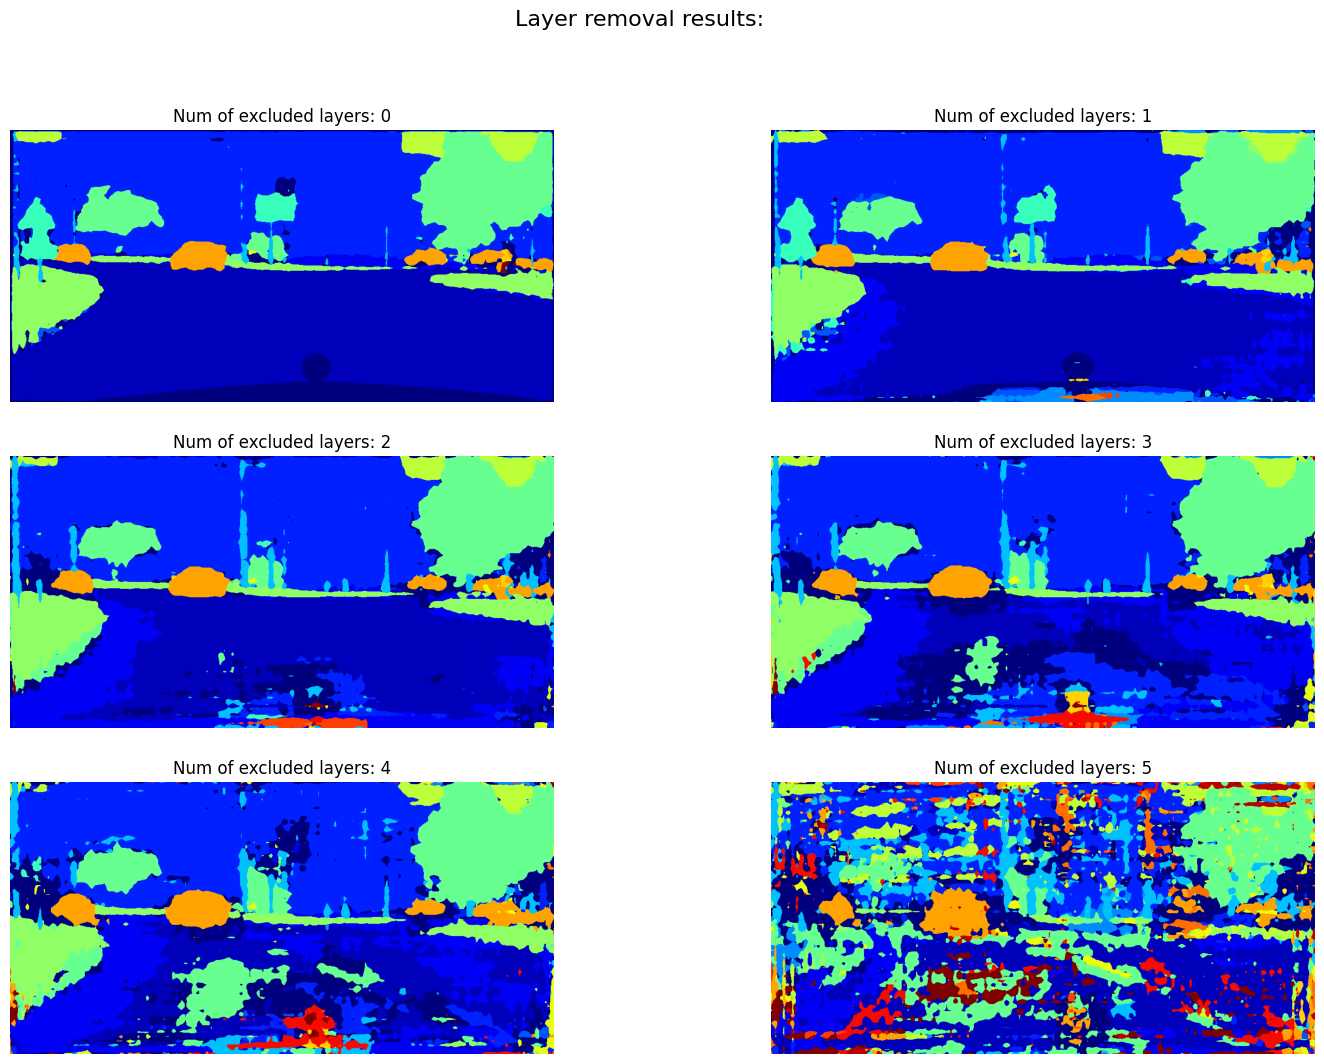

In [8]:
reducing_num_layers_study('aachen.png', 'model_8.pth')